In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest
import seaborn as sns

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

# Почему нельзя многократно применять обычные тесты

Посмотрим, что будет, если многократно применять обычный t-test к данным "одного" эксперимента:

Сначала посмотрим, какой эффект мы сможем поймать на данных, чтобы докидывать его при наших экспериментах

In [ ]:
def get_mde(metric_std, metric_n, metric_mean, alpha=0.05, beta=0.2):

    #metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1-(alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1-beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*np.sqrt(2)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

In [ ]:
get_mde(1, 500, 5, alpha=0.05, beta=0.2)

3.5437561393186385

Теперь сгенерируем данные, учитывая эффект и другие параметры, а потом проведем несколько раз t-test, как при проверке корректности критерия

In [ ]:
for _ in range(10):
    false_positive = []
    true_positive = []
    for _ in range(1000):
        vec_a = np.random.normal(5, 1, 250)
        vec_b_no_effect = np.random.normal(5, 1, 250)
        vec_b_with_effect = np.random.normal(5 * 1.035, 1, 250)
        _, pv_identical = stats.ttest_ind(vec_a, vec_b_no_effect)
        _, pv_effect = stats.ttest_ind(vec_a, vec_b_with_effect)
        false_positive.append(int(pv_identical < 0.05))
        true_positive.append(int(pv_effect < 0.05))
    print()
    print(f'I type error  : {np.mean(false_positive):0.3f}')
    print(f'II type error : {1 - np.mean(true_positive):0.3f}')


I type error  : 0.046
II type error : 0.494

I type error  : 0.044
II type error : 0.470

I type error  : 0.052
II type error : 0.533

I type error  : 0.054
II type error : 0.493

I type error  : 0.047
II type error : 0.495

I type error  : 0.047
II type error : 0.516

I type error  : 0.058
II type error : 0.487

I type error  : 0.062
II type error : 0.492

I type error  : 0.049
II type error : 0.526

I type error  : 0.067
II type error : 0.512


За исключением некоторых "выбросов" ошибка 1 рода не сильно выше заданного порога

Теперь попробуем добавлять данные в выборки и проводить тест

In [ ]:
def sequential_ttest(vec_a, vec_b, alpha):
    min_vec = min(len(vec_a), len(vec_b))
    for i in range(2, min_vec, 10): # для быстроты счета будем добавлять по несколько наблюдений сразу (аналог добавления данных батчами)
        vec_a_reduced = vec_a[:i]
        vec_b_reduced = vec_b[:i]
        _, pv = stats.ttest_ind(vec_a_reduced, vec_b_reduced)
        if pv < alpha: # если видим значимые различия, то возвращаем 1, если нет, то 0
            return 1
    return 0

In [ ]:
for _ in range(10):
    false_positive = []
    true_positive = []
    for _ in range(200):
        vec_a = np.random.normal(5, 1, 250)
        vec_b_no_effect = np.random.normal(5, 1, 250)
        vec_b_with_effect = np.random.normal(5 * 1.035, 1, 250)
        false_positive.append(sequential_ttest(vec_a, vec_b_no_effect, 0.05))
        true_positive.append(sequential_ttest(vec_a, vec_b_with_effect, 0.05))
    print()
    print(f'I type error  : {np.mean(false_positive):0.3f}')
    print(f'II type error : {1 - np.mean(true_positive):0.3f}')


I type error  : 0.315
II type error : 0.265

I type error  : 0.260
II type error : 0.320

I type error  : 0.305
II type error : 0.280

I type error  : 0.290
II type error : 0.310

I type error  : 0.255
II type error : 0.300

I type error  : 0.330
II type error : 0.320

I type error  : 0.300
II type error : 0.320

I type error  : 0.295
II type error : 0.350

I type error  : 0.235
II type error : 0.315

I type error  : 0.365
II type error : 0.335


Видим, что теперь ошибка 1 рода сильно выросла. Почему так получилось?

# Метод Вальда (классический)

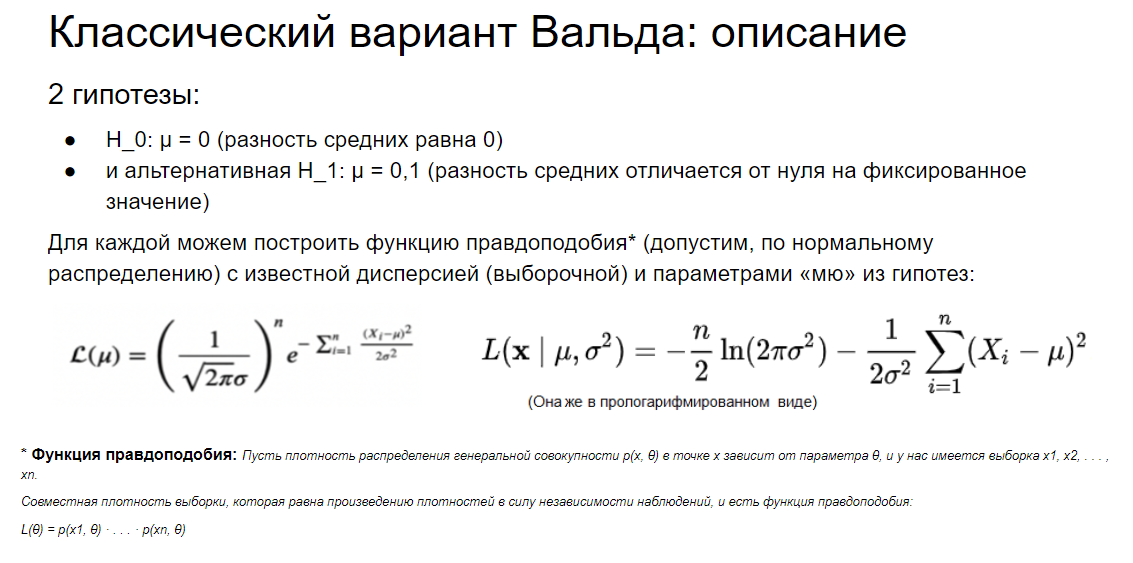

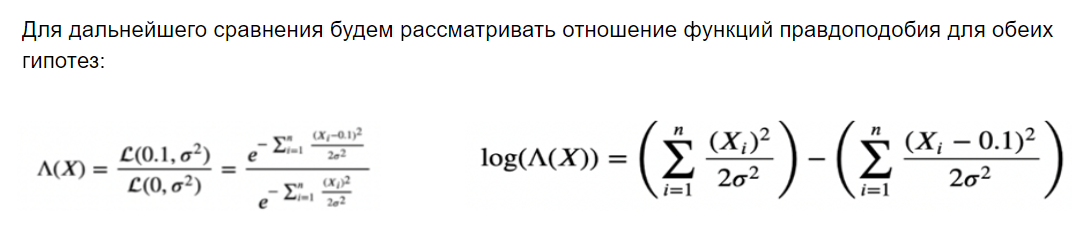

In [ ]:
# Создадим класс, реализующий логику метода Вальда

class WaldSequentialAnalysis:
    def __init__(self, mean, std, effect, alpha, beta):
        self.mean = mean
        self.std = std
        self.effect = effect
        self.alpha = alpha
        self.beta = beta
        self.lower_bound = np.log(beta / (1 - alpha)) # здесь мы вычисляем границы
        self.upper_bound = np.log((1 - beta) / alpha)

    def log_pdf_one(self, x):
        """Логарифм функции плотности разницы средних при верности нулевой гипотезы."""
        return stats.norm.logpdf(x, 0, np.sqrt(2) * self.std)

    def log_pdf_two(self, x):
        """Логарифм функции плотности разницы средних при верности альтернативной гипотезы."""
        return stats.norm.logpdf(x, self.mean * (self.effect - 1), np.sqrt(2) * self.std)

    def test(self, data_one, data_two):
        """Проверяет наличие значимых отличий по мере поступления данных."""
        min_len = min(len(data_one), len(data_two))
        for i in range(1, min_len):
            sub_data_one = data_one[:i]
            sub_data_two = data_two[:i]
            delta_sub_data = sub_data_two - sub_data_one
            log_pdf_one_values = self.log_pdf_one(delta_sub_data)
            log_pdf_two_values = self.log_pdf_two(delta_sub_data)
            z = np.sum(log_pdf_two_values - log_pdf_one_values)
            # далее будем проверять условия остановки
            if z < self.lower_bound:
                return 0, i
            if z > self.upper_bound:
                return 1, i
        return 0.5, i



In [ ]:
# Функция для отрисовки теста
def plot_wald_test(wald_test, data_one, data_two):
    fig, ax = plt.subplots(figsize=(10, 6))

    zs = []
    for i in range(1, len(data_one)):
        sub_data_one = data_one[:i]
        sub_data_two = data_two[:i]
        delta_sub_data = sub_data_two - sub_data_one
        log_pdf_one_values = wald_test.log_pdf_one(delta_sub_data)
        log_pdf_two_values = wald_test.log_pdf_two(delta_sub_data)
        z = np.sum(log_pdf_two_values - log_pdf_one_values)
        zs.append(z)

    result, stop_point = wald_test.test(data_one, data_two)
    ax.plot(zs, label='Статистика Z', color='blue')
    ax.axhline(wald_test.upper_bound, color='red', linestyle='--', label='Верхняя граница')
    ax.axhline(wald_test.lower_bound, color='green', linestyle='--', label='Нижняя граница')
    ax.axvline(stop_point, color='orange', linestyle='-.', label=f'Прекращение на шаге {stop_point}')

    ax.set_xlabel('Количество наблюдений')
    ax.set_ylabel('Сумма логарифмов правдоподобий')
    ax.set_title('Вальдовский процесс последовательного анализа')
    ax.legend()
    plt.show()

    # График 2: Сравнение распределений
    plt.subplot(2, 1, 1)
    plt.hist(data_one, bins=30, alpha=0.5, label='Группа 1')
    plt.hist(data_two, bins=30, alpha=0.5, label='Группа 2')
    plt.axvline(np.mean(data_one), color='b', linestyle='--')
    plt.axvline(np.mean(data_two), color='r', linestyle='--')
    plt.title('Распределение данных')
    plt.legend()

Посмотрим, как это работает

In [ ]:
mean = 5
std = 1
effect = 1.05
alpha = 0.05
beta = 0.2
sample_size_ = 250

data_a_one = np.random.normal(mean, std, sample_size_)
data_a_two = np.random.normal(mean, std, sample_size_)
data_b = np.random.normal(mean * effect, std, sample_size_)

wald = WaldSequentialAnalysis(mean, std, effect, alpha, beta)
result_no_effect, n_steps_no_effect = wald.test(data_a_one, data_a_two)

In [ ]:
result_no_effect, n_steps_no_effect

(0, 25)

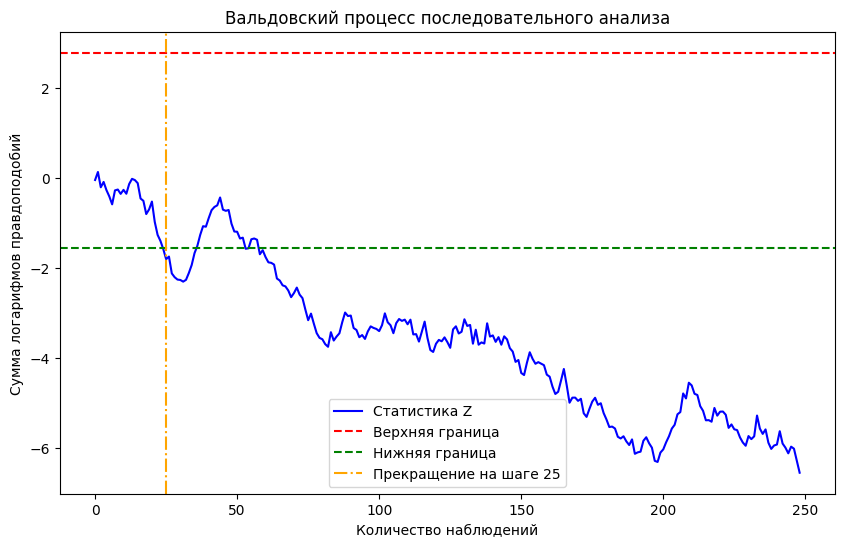

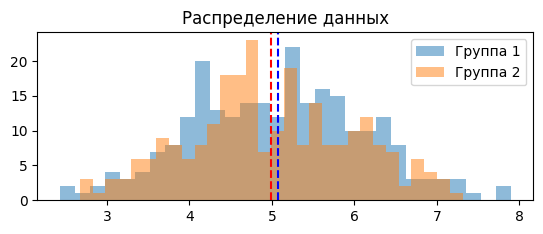

In [ ]:
plot_wald_test(wald, data_a_one, data_a_two)

In [ ]:
result_effect, n_steps_effect = wald.test(data_a_one, data_b)
result_effect, n_steps_effect

(1, 45)

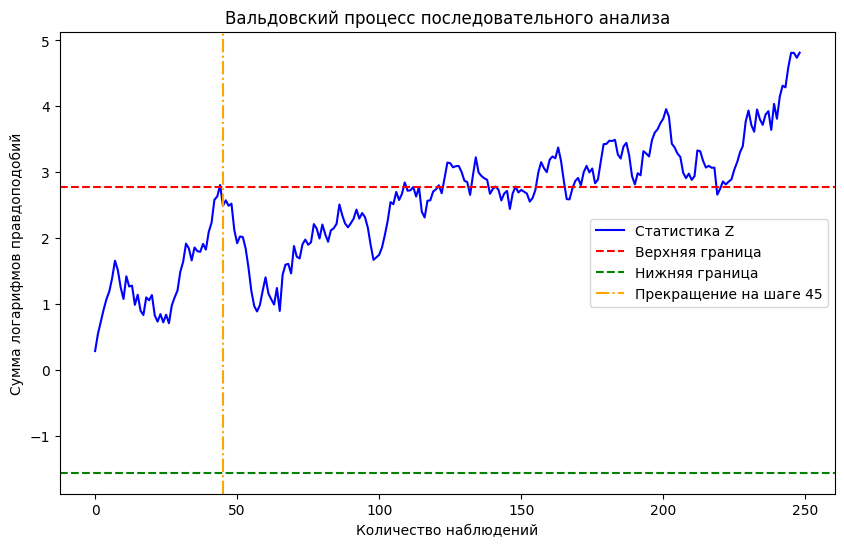

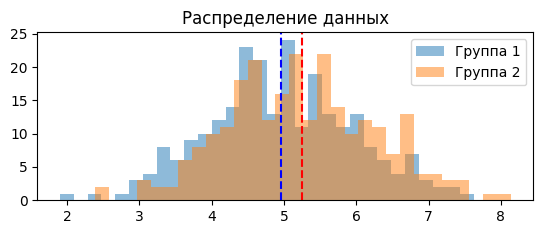

In [ ]:
plot_wald_test(wald, data_a_one, data_b)

# Сравним мощности метода Вальда и стандартного теста Стьюдента

На лекции мы говорили о сравнении мощностей t-test и always valid p-values, теперь сами проверим классический метод Вальда

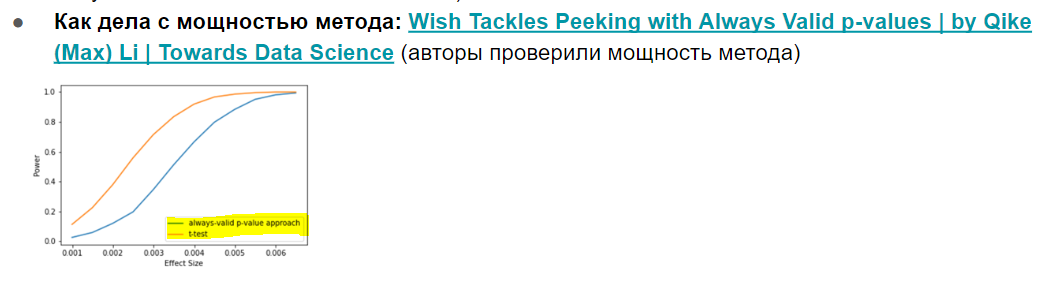

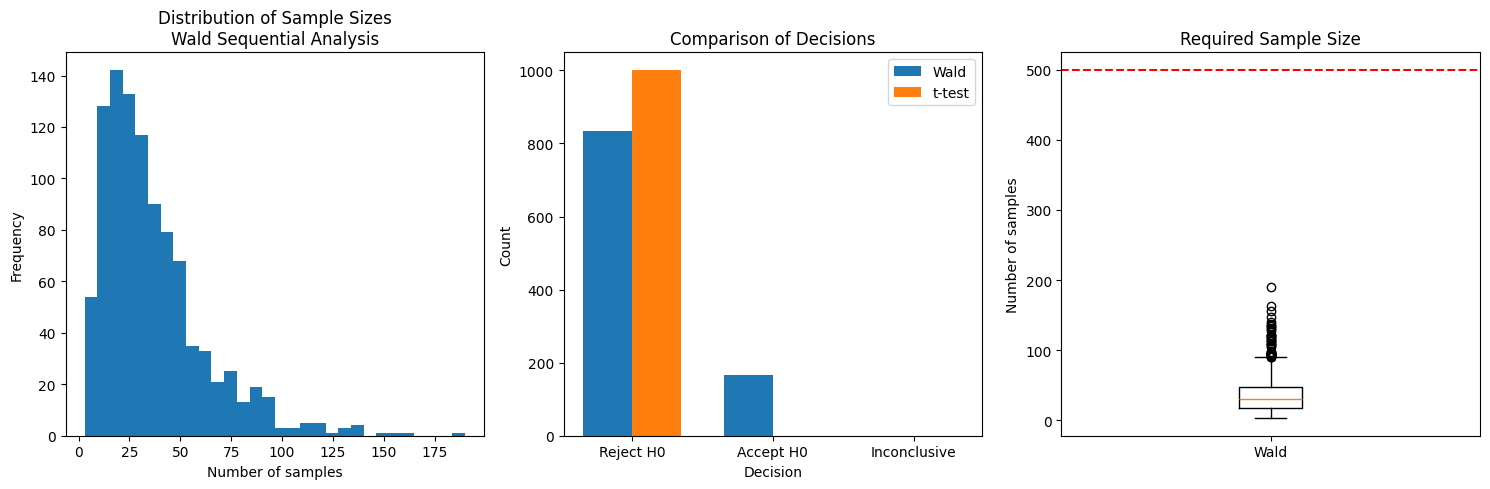

Average samples needed (Wald): 36.49
Fixed samples (t-test): 500

Wald decisions:
Reject H0: 83.4%
Accept H0: 16.6%
Inconclusive: 0.0%

t-test decisions:
Reject H0: 100.0%
Accept H0: 0.0%


In [ ]:
def compare_wald_ttest(mean, std, effect, sample_size, n_simulations=1000, alpha = 0.05, beta = 0.2):
    # Инициализация анализатора Вальда
    wald = WaldSequentialAnalysis(mean, std, effect, alpha, beta)

    # Массивы для хранения результатов
    wald_decisions = []
    wald_samples = []
    ttest_decisions = []

    for _ in range(n_simulations):
        # Генерация данных
        control = np.random.normal(mean, std, sample_size)
        test = np.random.normal(mean * effect, std, sample_size)

        # Анализ методом Вальда
        wald_decision, wald_n = wald.test(control, test)
        wald_decisions.append(wald_decision)
        wald_samples.append(wald_n)

        # t-тест
        _, p_value = stats.ttest_ind(control, test)
        ttest_decisions.append(1 if p_value < alpha else 0)

    # Построение графиков
    plt.figure(figsize=(15, 5))

    # График 1: Распределение количества образцов для метода Вальда
    plt.subplot(131)
    plt.hist(wald_samples, bins=30)
    plt.title('Distribution of Sample Sizes\nWald Sequential Analysis')
    plt.xlabel('Number of samples')
    plt.ylabel('Frequency')

    # График 2: Сравнение решений
    plt.subplot(132)
    labels = ['Reject H0', 'Accept H0', 'Inconclusive']
    wald_counts = [
        sum(1 for x in wald_decisions if x == 1),
        sum(1 for x in wald_decisions if x == 0),
        sum(1 for x in wald_decisions if x == 0.5)
    ]
    ttest_counts = [
        sum(1 for x in ttest_decisions if x == 1),
        sum(1 for x in ttest_decisions if x == 0),
        0
    ]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, wald_counts, width, label='Wald')
    plt.bar(x + width/2, ttest_counts, width, label='t-test')
    plt.xlabel('Decision')
    plt.ylabel('Count')
    plt.title('Comparison of Decisions')
    plt.xticks(x, labels)
    plt.legend()

    # График 3: Среднее количество образцов
    plt.subplot(133)
    plt.boxplot([wald_samples])
    plt.axhline(y=sample_size, color='r', linestyle='--', label='t-test (fixed)')
    plt.title('Required Sample Size')
    plt.ylabel('Number of samples')
    plt.xticks([1], ['Wald'])

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print(f"Average samples needed (Wald): {np.mean(wald_samples):.2f}")
    print(f"Fixed samples (t-test): {sample_size}")
    print(f"\nWald decisions:")
    print(f"Reject H0: {wald_counts[0]/n_simulations*100:.1f}%")
    print(f"Accept H0: {wald_counts[1]/n_simulations*100:.1f}%")
    print(f"Inconclusive: {wald_counts[2]/n_simulations*100:.1f}%")
    print(f"\nt-test decisions:")
    print(f"Reject H0: {ttest_counts[0]/n_simulations*100:.1f}%")
    print(f"Accept H0: {ttest_counts[1]/n_simulations*100:.1f}%")

# Запуск сравнения
compare_wald_ttest(5, 1, 1.1, 500)

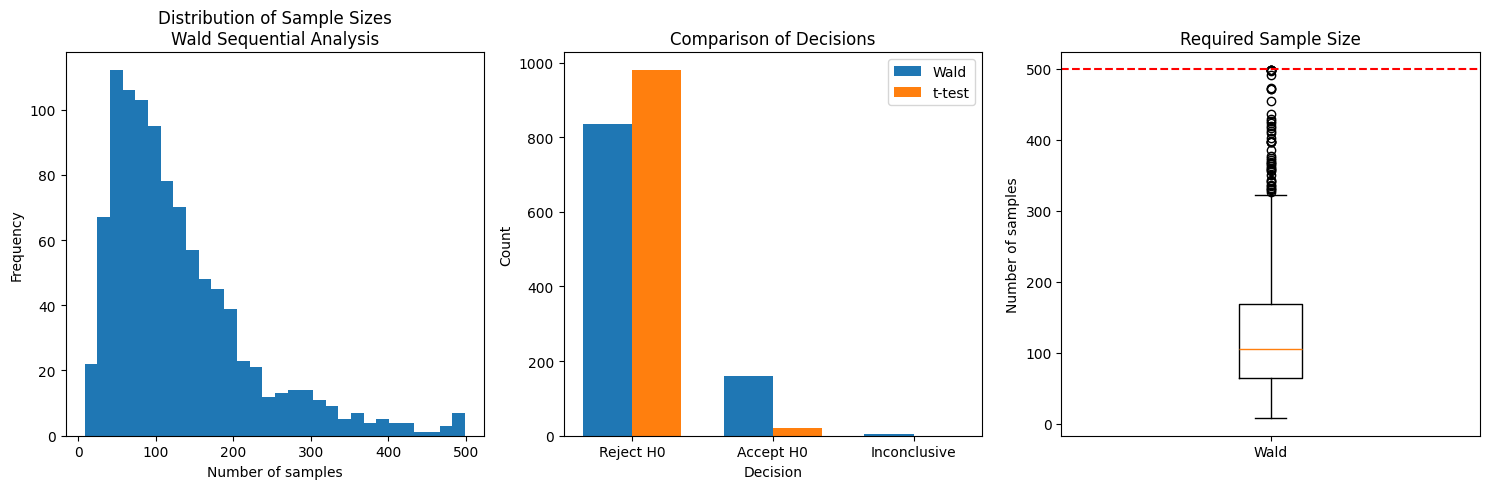

Average samples needed (Wald): 129.97
Fixed samples (t-test): 500

Wald decisions:
Reject H0: 83.6%
Accept H0: 15.9%
Inconclusive: 0.5%

t-test decisions:
Reject H0: 97.9%
Accept H0: 2.1%


In [ ]:
compare_wald_ttest(5, 1, 1.05, 500)

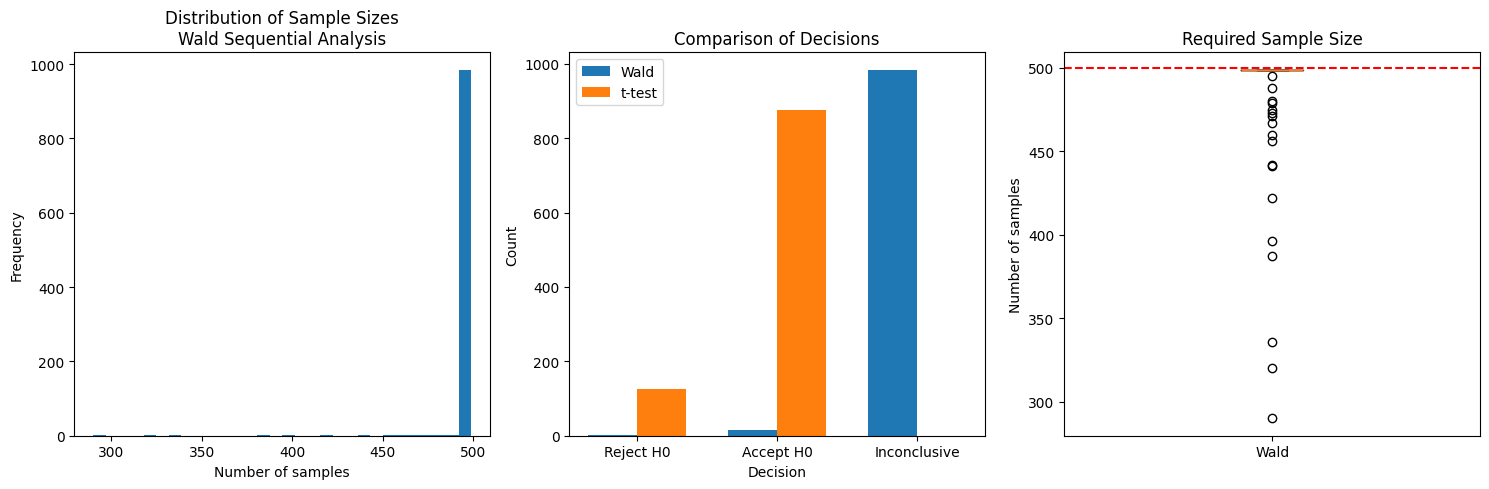

Average samples needed (Wald): 497.80
Fixed samples (t-test): 500

Wald decisions:
Reject H0: 0.2%
Accept H0: 1.6%
Inconclusive: 98.2%

t-test decisions:
Reject H0: 12.5%
Accept H0: 87.5%


In [ ]:
compare_wald_ttest(5, 1, 1.01, 500)

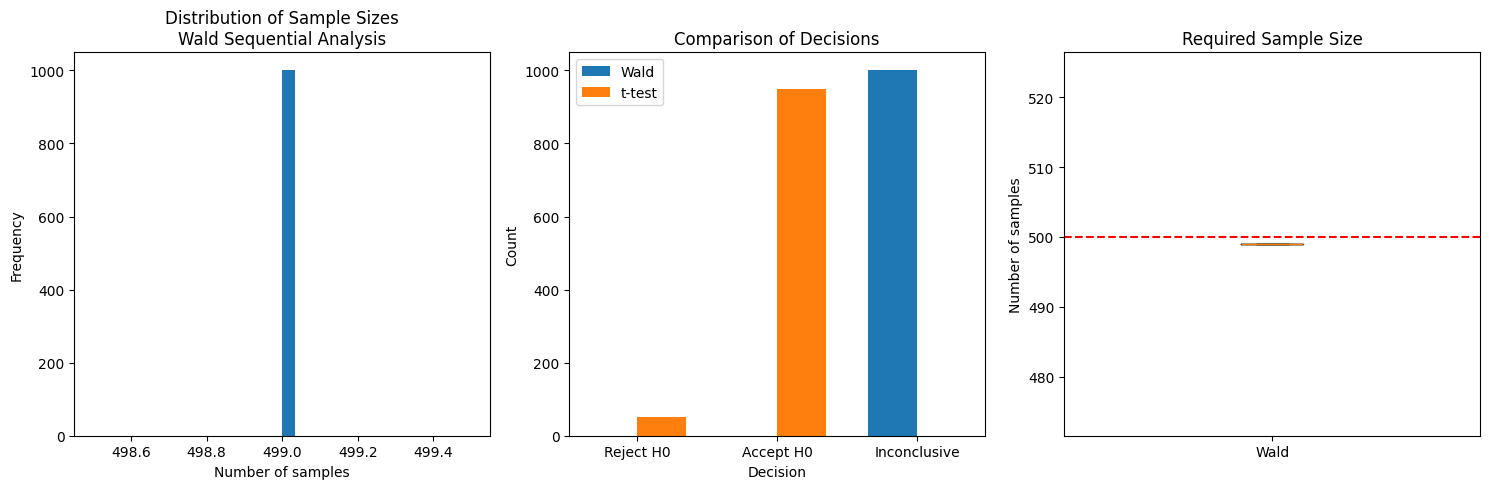

Average samples needed (Wald): 499.00
Fixed samples (t-test): 500

Wald decisions:
Reject H0: 0.0%
Accept H0: 0.0%
Inconclusive: 100.0%

t-test decisions:
Reject H0: 5.0%
Accept H0: 95.0%


In [ ]:
compare_wald_ttest(5, 1, 1.0, 500)

Теперь проверим, насколько контролируется ошибка 1 рода в классическом подходе Вальда

В лекции рассматривали контроль ошибки 1 рода для always valid p-values, там все было хорошо

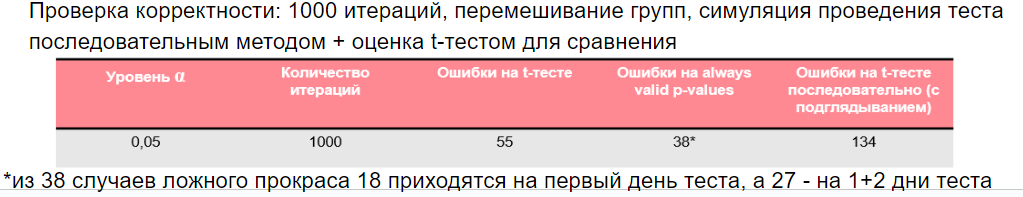

In [ ]:
np.random.seed(42)

mean = 5
std = 1
effect = 1.05
alpha = 0.05
beta = 0.2

sample_size_ = 1000

for _ in range(10):
    false_positive = []
    true_positive = []
    list_length_aa = []
    list_length_ab = []
    for _ in range(200):
        data_a_one = np.random.normal(mean, std, sample_size_)
        data_a_two = np.random.normal(mean, std, sample_size_)
        data_b = np.random.normal(mean * effect, std, sample_size_)
        wald = WaldSequentialAnalysis(
            mean, std, effect, alpha, beta
        )
        test_result_aa, length_aa = wald.test(data_a_one, data_a_two)
        test_result_ab, length_ab = wald.test(
            data_a_one, data_b
        )
        false_positive.append(test_result_aa)
        true_positive.append(test_result_ab)
        list_length_aa.append(length_aa)
        list_length_ab.append(length_ab)
    print()
    print(f'I type error  : {np.mean(false_positive):0.3f}')
    print(f'II type error : {1 - np.mean(true_positive):0.3f}')


I type error  : 0.045
II type error : 0.175

I type error  : 0.035
II type error : 0.215

I type error  : 0.035
II type error : 0.130

I type error  : 0.050
II type error : 0.140

I type error  : 0.065
II type error : 0.155

I type error  : 0.015
II type error : 0.170

I type error  : 0.040
II type error : 0.210

I type error  : 0.045
II type error : 0.165

I type error  : 0.040
II type error : 0.130

I type error  : 0.045
II type error : 0.205


Видим, что ошибка 1 рода не растет по мере увеличения количества тестов, метод Вальда контролирует ошибку

#А теперь упрощенная версия - библиотека SPRT

In [ ]:
pip install sprt

In [ ]:
import sprt

[Ссылка на гитхаб с библиотекой](https://github.com/Testispuncher/Sequential-Probability-Ratio-Test)

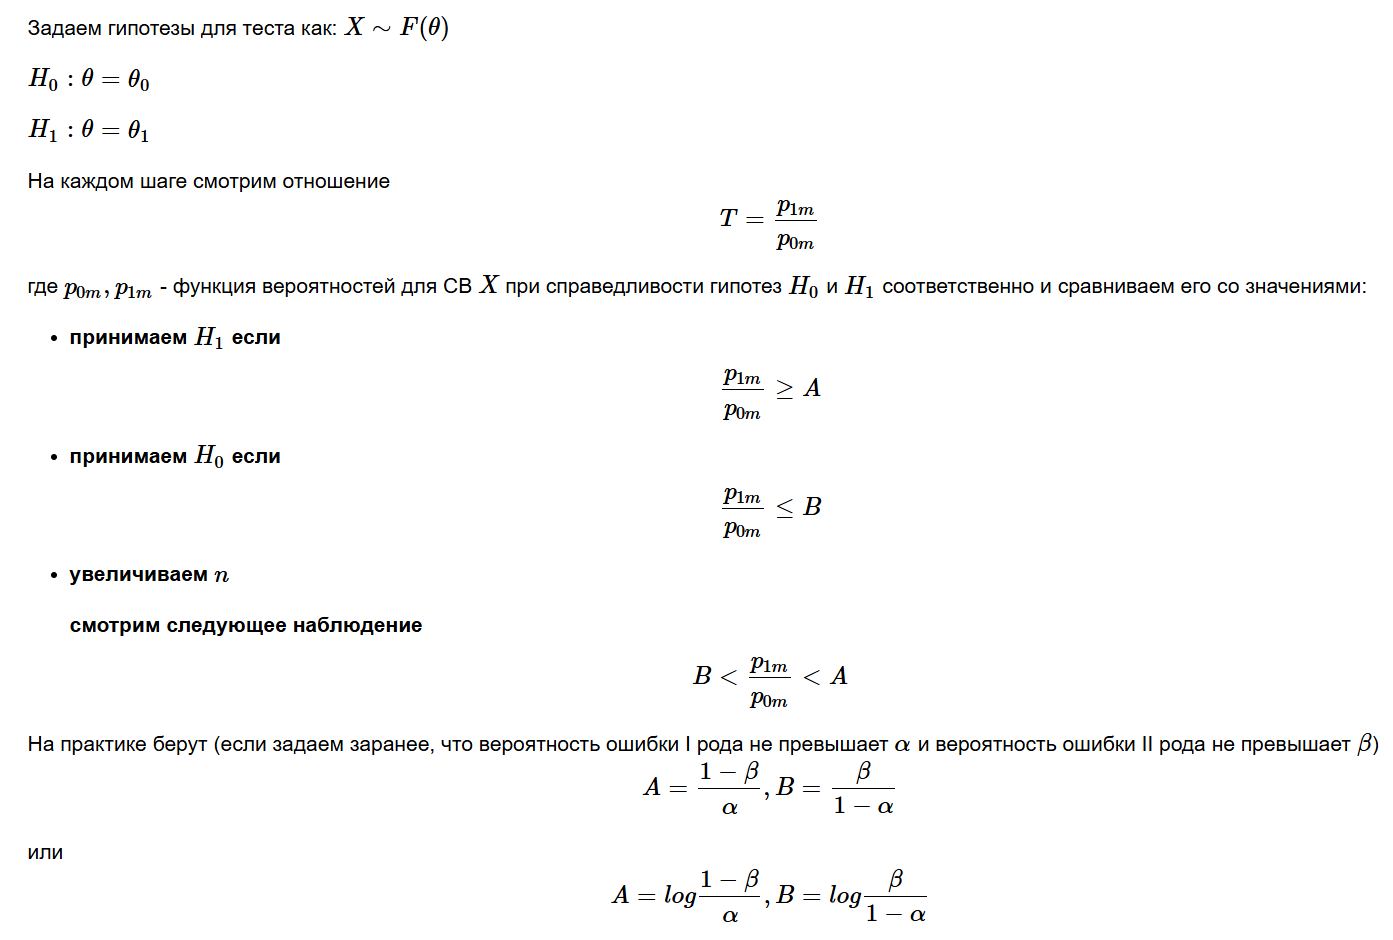

# Пример для биномиального распределения

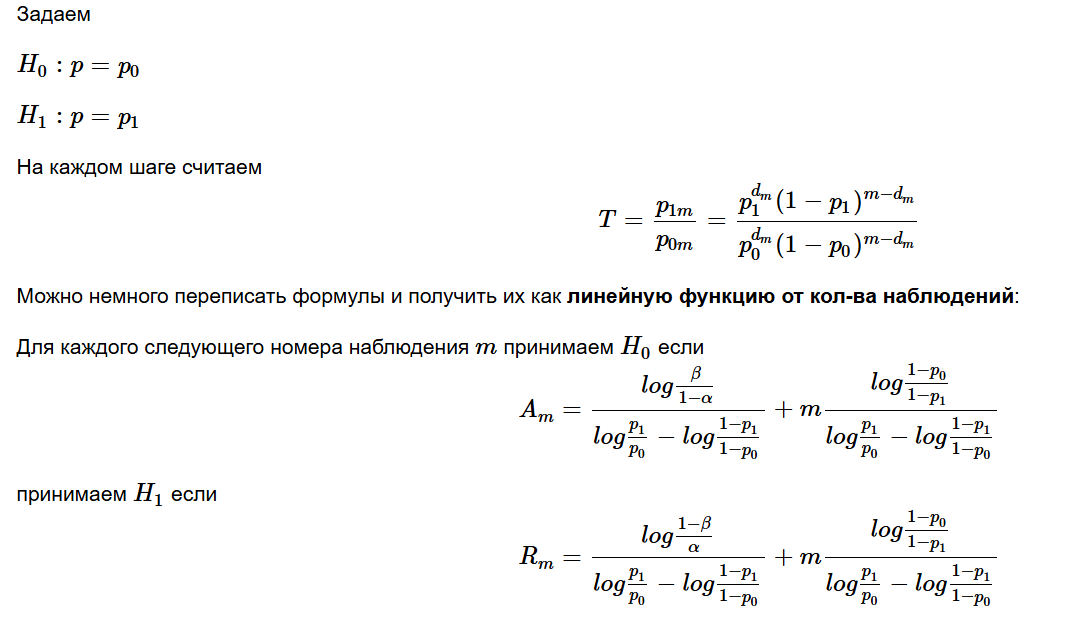

Decision:	Continue

    values  lower   upper
n                        
11       4  3.579   8.919
12       4  4.079   9.419
13       5  4.579   9.919
14       6  5.079  10.419
15       6  5.579  10.919
16       6  6.079  11.419
17       6  6.579  11.919
18       7  7.079  12.419
19       8  7.579  12.919
20       9  8.079  13.419


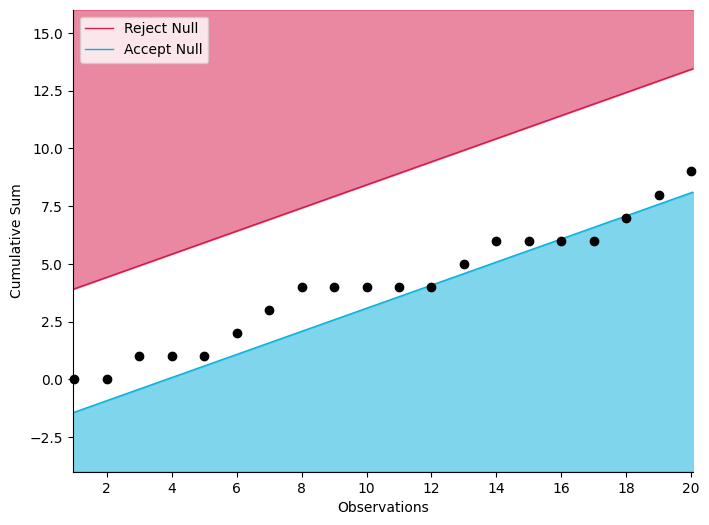

In [ ]:
# значение ф-и вероятности p0 для Н0
p0 = 0.4
# aзначение ф-и вероятности p1 для Н1
p1 = 0.6

# параметр ошибки I рода
alpha = 0.05
# параметр ошибки II рода
beta = 0.2

# сгенерируем наблюдения биномиальным распределением
values = np.random.binomial(1, 0.35, 20)
binomial_test = sprt.SPRTBinomial(values=values, h0=p0, h1=p1, alpha=alpha, beta=beta)
binomial_test.plot()

In [ ]:
values[:12]

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])

Decision:	Reject

     values   lower   upper
n                          
91       69  43.579  48.919
92       69  44.079  49.419
93       69  44.579  49.919
94       70  45.079  50.419
95       71  45.579  50.919
96       71  46.079  51.419
97       71  46.579  51.919
98       72  47.079  52.419
99       72  47.579  52.919
100      72  48.079  53.419


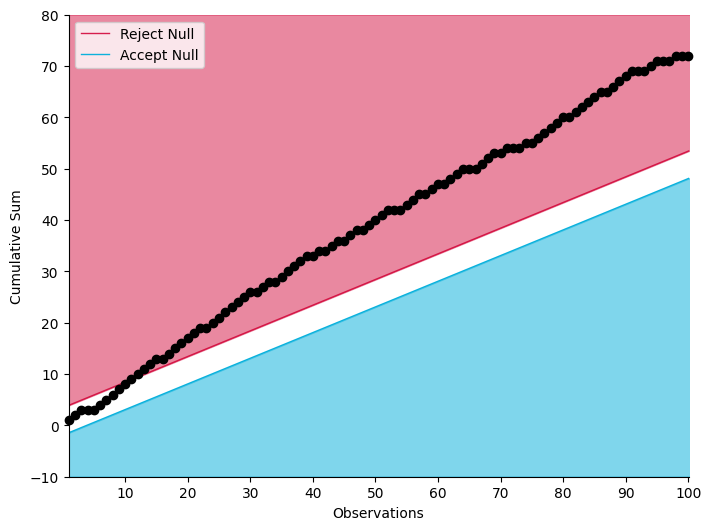

In [ ]:
# значение ф-и вероятности p0 для Н0
p0 = 0.4
# значение ф-и вероятности p1 для Н1
p1 = 0.6

# параметр ошибки I рода
alpha = 0.05
# параметр ошибки II рода
beta = 0.2

# сгенерируем наблюдения биномиальным распределением
values = np.random.binomial(1, 0.7, 100)

binomial_test = sprt.SPRTBinomial(values=values, h0=p0, h1=p1, alpha=alpha, beta=beta)

binomial_test.plot()

Уменьшим количество наблюдений, сохранив параметры распределения и вероятности неизменными

Decision:	Continue

   values  lower  upper
n                      
1       0 -1.421  3.919
2       0 -0.921  4.419
3       0 -0.421  4.919
4       1  0.079  5.419
5       2  0.579  5.919


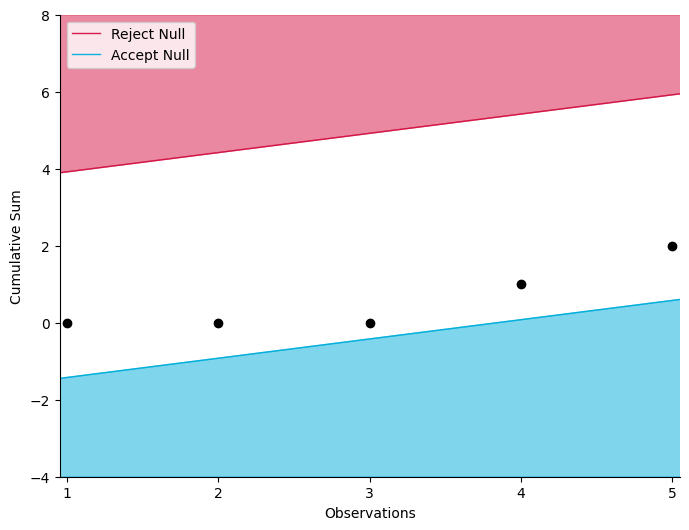

In [ ]:
# значение ф-и вероятности p0 для Н0
p0 = 0.4
# значение ф-и вероятности p1 для Н1
p1 = 0.6

# параметр ошибки I рода
alpha = 0.05
# параметр ошибки II рода
beta = 0.2

# сгенерируем наблюдения биномиальным распределением
values = np.random.binomial(1, 0.7, 5)

binomial_test = sprt.SPRTBinomial(values=values, h0=p0, h1=p1, alpha=alpha, beta=beta)

binomial_test.plot()

То же самое можно проделать и для нормального распределения

In [ ]:
test = sprt.SPRTNormal(alpha = 0.05, beta = 0.2, h0 = 0, h1 = 0.8,
values = np.random.normal(0, 1, 100),
variance = 1)

Decision:	Accept

     values   lower   upper
n                          
91  -10.293  34.452  39.866
92  -10.436  34.852  40.266
93  -10.731  35.252  40.666
94  -10.509  35.652  41.066
95   -9.177  36.052  41.466
96   -9.113  36.452  41.866
97   -8.862  36.852  42.266
98   -9.153  37.252  42.666
99   -8.749  37.652  43.066
100  -9.856  38.052  43.466


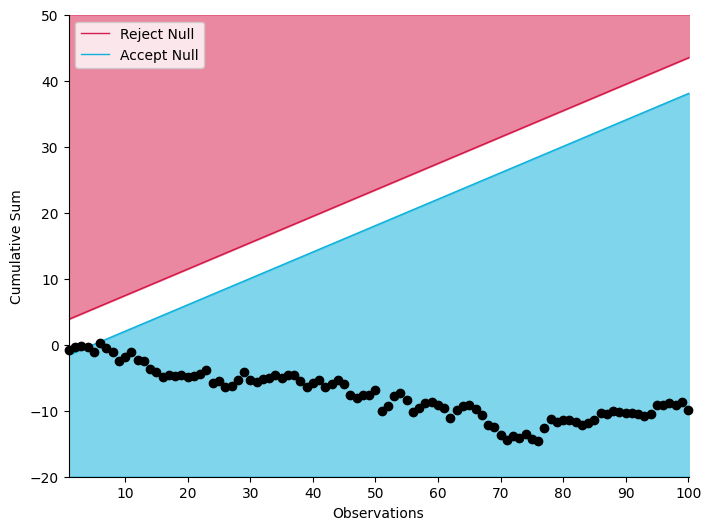

In [ ]:
test.plot()